## Using multiple policies in the same environment

In [1]:
import torch
import dataclasses
import mediapy
from huggingface_hub import PyTorchModelHubMixin
from huggingface_hub import ModelCard
from gpudrive.networks.late_fusion import NeuralNet
from gpudrive.env.config import EnvConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.env.dataset import SceneDataLoader
from gpudrive.utils.config import load_config 

from gpudrive.utils.rollout import multi_policy_rollout

### Helper function

In [2]:
def create_policy_masks(env, num_sim_agents=2, num_worlds=10):
    """
    Create policy masks for multiple agents across different worlds.
    
    Args:
        env: The environment object containing agent mask information
        num_sim_agents: Number of simultaneous agents to create policies for
        num_worlds: Number of simulation worlds
        
    Returns:
        Dictionary of policy masks with keys 'pi_1', 'pi_2', etc.
    """
    # Initialize policy mask with zeros (same shape as cont_agent_mask)
    policy_mask = torch.zeros_like(env.cont_agent_mask, dtype=torch.int)
    
    # Get indices of controlled agents
    agent_indices = env.cont_agent_mask.nonzero(as_tuple=True)

    # Assign policy numbers (1 to num_sim_agents) to each agent in a round-robin fashion
    for i, (world_idx, agent_idx) in enumerate(zip(*agent_indices)):
        policy_mask[world_idx, agent_idx] = (i % num_sim_agents) + 1

    # Create a dictionary of empty boolean masks for each policy
    policy_masks = {
        f'pi_{int(policy.item())}': torch.zeros_like(
            env.cont_agent_mask, 
            dtype=torch.bool,
            device=env.cont_agent_mask.device  # Use the same device as the mask
        ) 
        for policy in policy_mask.unique() if policy.item() != 0
    }

    # Fill in the boolean masks for each policy
    for p in range(1, num_sim_agents + 1):
        policy_masks[f'pi_{p}'] = (policy_mask == p).reshape(num_worlds, -1)

    return policy_masks

In [3]:
# Configs model has been trained with
config = load_config("../../examples/experimental/config/reliable_agents_params")
max_agents = config.max_controlled_agents
NUM_ENVS = 2
device = "cpu" # cpu just because we're in a notebook
NUM_SIM_AGENTS = 2
FPS = 5

sim_agent1 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S10_000_02_27")
sim_agent2 = NeuralNet.from_pretrained("daphne-cornelisse/policy_S1000_02_27")

### Make environment

In [4]:
train_loader = SceneDataLoader(
    root='../../data/processed/examples',
    batch_size=NUM_ENVS,
    dataset_size=100,
    sample_with_replacement=False,
)

# Set params
env_config = dataclasses.replace(
    EnvConfig(),
    ego_state=config.ego_state,
    road_map_obs=config.road_map_obs,
    partner_obs=config.partner_obs,
    reward_type=config.reward_type,
    norm_obs=config.norm_obs,
    dynamics_model=config.dynamics_model,
    collision_behavior=config.collision_behavior,
    dist_to_goal_threshold=config.dist_to_goal_threshold,
    polyline_reduction_threshold=config.polyline_reduction_threshold,
    remove_non_vehicles=config.remove_non_vehicles,
    lidar_obs=config.lidar_obs,
    disable_classic_obs=config.lidar_obs,
    obs_radius=config.obs_radius,
    steer_actions = torch.round(
        torch.linspace(-torch.pi, torch.pi, config.action_space_steer_disc), decimals=3  
    ),
    accel_actions = torch.round(
        torch.linspace(-4.0, 4.0, config.action_space_accel_disc), decimals=3
    ),
)

env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=train_loader,
    max_cont_agents=max_agents,
    device=device,
)

### Rollout

In [5]:
next_obs = env.reset()

control_mask = env.cont_agent_mask

# Create policy masks for 2 agents across NUM_ENVS worlds
policy_mask = create_policy_masks(env, num_sim_agents=2, num_worlds=NUM_ENVS)

# Define the policy set with agent models and their corresponding masks
policies_set = {
    'pi_1': (sim_agent1, policy_mask['pi_1']),
    'pi_2': (sim_agent2, policy_mask['pi_2'])
}

# Rollout with multiple policies
metrics, frames = multi_policy_rollout(
    env=env,
    policies=policies_set,
    device=device,
    deterministic=False,
    render_sim_state=True,
    render_every_n_steps=5
)

env.close()

0,1

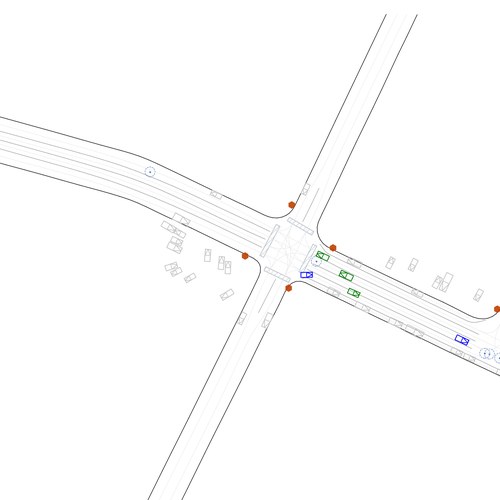
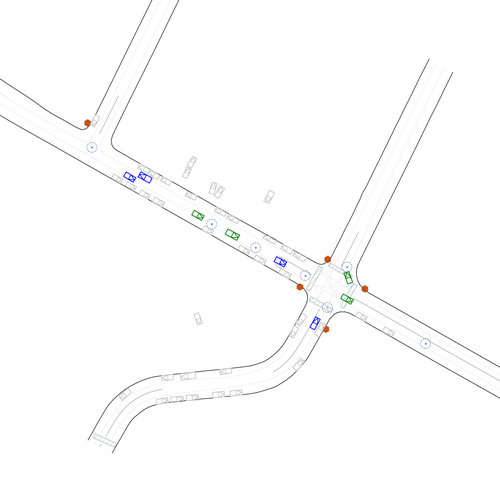

In [6]:
mediapy.show_videos(frames, fps=10, width=500, height=500, columns=2, codec='gif')